# Preparación de data

## Fuente de logs

### Funciones de limpieza y anonimización

In [ ]:
import re
import os
import hashlib
from typing import Optional, Dict, Tuple

import pandas as pd
import numpy as np

try:
    import sqlparse
    HAS_SQLPARSE = True
except Exception:
    HAS_SQLPARSE = False


DEFAULT_SALT = os.environ.get("ANON_SALT", "Salt para hasheo de info anónimizada")

EXPECTED_COLS = [
    "ID", "Proceso", "Ejecucion", "Inicio", "Fin", "Descripcion",
    "Procedimiento", "Query", "Leads", "Error", "Error_Mensaje", "Usuario"
]

TEXT_COLS = ["Proceso", "Ejecucion", "Descripcion", "Procedimiento", "Query", "Error_Mensaje", "Usuario"]
DATETIME_COLS = ["Inicio", "Fin"]
BOOLISH_COLS = ["Error"]


def stable_hash(value: str, salt: str = DEFAULT_SALT, prefix: str = "usr_") -> str:
    """Hash estable (SHA256) con salt, para anonimizar Usuario u otros IDs."""
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return None
    v = str(value).strip()
    if not v:
        return None
    h = hashlib.sha256((salt + "::" + v).encode("utf-8")).hexdigest()[:16]
    return f"{prefix}{h}"



PATRON_INFO_PERSONAL: Tuple[Tuple[str, re.Pattern], ...] = (
    ("EMAIL", re.compile(r"\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[A-Za-z]{2,}\b")),
    ("IP",    re.compile(r"\b(?:\d{1,3}\.){3}\d{1,3}\b")),
    ("DNI",   re.compile(r"\b\d{8}\b")),
    ("RUC",   re.compile(r"\b\d{11}\b")),
    ("PHONE", re.compile(r"\b(?:\+?51\s*)?(?:9\d{8}|(?:\d{2,3}[\s-]?)?\d{6,7})\b")),
    ("CARD",  re.compile(r"\b\d{13,19}\b")),
)

def redact_info_personal(text: Optional[str]) -> Optional[str]:
    if text is None or (isinstance(text, float) and np.isnan(text)):
        return None
    s = str(text)
    for tag, pat in PATRON_INFO_PERSONAL:
        s = pat.sub(f"<{tag}>", s)
    return s


RE_SQL_SINGLE_QUOTE = re.compile(r"('([^']|'' )*')")  # strings simples (con comillas)
RE_SQL_STRINGS = re.compile(r"'([^']|'')*'")         # strings SQL (maneja '' escapado)
RE_SQL_NUMBERS = re.compile(r"(?<![\w@#])(-?\d+(?:\.\d+)?)(?![\w@#])")  # números aislados
RE_SQL_HEX = re.compile(r"\b0x[0-9A-Fa-f]+\b")
RE_SQL_GUID = re.compile(r"\b[0-9a-fA-F]{8}\-[0-9a-fA-F]{4}\-[0-9a-fA-F]{4}\-[0-9a-fA-F]{4}\-[0-9a-fA-F]{12}\b")

EXCEL_ARTIFACT_RE = re.compile(r"_x0{3}D_", flags=re.IGNORECASE)

def strip_excel_artifacts(s: str) -> str:
    """Limpieza de saltos de línea de SQL que se cargan en excel"""
    if s is None:
        return s

    s = EXCEL_ARTIFACT_RE.sub("\n", s)


    s = s.replace("\r", "\n")

    return s


def _clean_field(x):
    """Quita | al inicio/fin, espacios, comillas externas y artefactos Excel."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None

    s = str(x)

    s = strip_excel_artifacts(s)

    s = s.strip()

    s = s.strip("|").strip()

    if len(s) >= 2 and s[0] == s[-1] == '"':
        s = s[1:-1]

    return s



def normalize_sql(sql: Optional[str], keep_case: bool = False) -> Optional[str]:
    if sql is None or (isinstance(sql, float) and np.isnan(sql)):
        return None
    s = str(sql).strip()
    if not s:
        return None

    #Limpieza básica espacios en blanco
    s = re.sub(r"[ \t]+", " ", s)
    s = re.sub(r"\s*\n\s*", " ", s)

    #Redacta la info personal primero (emails, IP, etc.)
    s = redact_info_personal(s)

    #Parametriza GUID / HEX
    s = RE_SQL_GUID.sub("@p_guid", s)
    s = RE_SQL_HEX.sub("@p_hex", s)

    #Parametriza strings
    s = RE_SQL_STRINGS.sub("@p_str", s)

    #Parametriza números aislados
    s = RE_SQL_NUMBERS.sub("@p_num", s)

    #Formateo opcional con sqlparse
    if HAS_SQLPARSE:
        try:
            s = sqlparse.format(
                s,
                reindent=False,
                keyword_case=None if keep_case else "upper",
                identifier_case=None,
                strip_comments=True,
                use_space_around_operators=True
            )
        except Exception:
            pass

    #Quita dobles espacios finales
    s = re.sub(r"\s{2,}", " ", s).strip()
    return s

def ensure_columns(df: pd.DataFrame, expected: list = EXPECTED_COLS) -> pd.DataFrame:
    """Garantiza que existan columnas esperadas; si faltan, las crea con NaN."""
    for c in expected:
        if c not in df.columns:
            df[c] = np.nan
    ordered = expected + [c for c in df.columns if c not in expected]
    return df[ordered]



def clean_and_anonymize_sql_log(
    df: pd.DataFrame,
    salt: str = DEFAULT_SALT,
    drop_error_queries: bool = False,
    keep_original_query: bool = True
) -> pd.DataFrame:
    df = df.copy()
    df = ensure_columns(df)

    # 1) Limpieza de strings aplicando _clean_field (incluye _x000D_)
    for c in TEXT_COLS:
        if c in df.columns:
            df[c] = df[c].apply(_clean_field)

    # 2) Tipos básicos
    if "ID" in df.columns:
        df["ID"] = pd.to_numeric(df["ID"], errors="coerce")
    if "Leads" in df.columns:
        df["Leads"] = pd.to_numeric(df["Leads"], errors="coerce")

    # 3) Error: 0/1
    if "Error" in df.columns:
        df["Error"] = df["Error"].astype("string").str.lower().replace({
            "true": "1", "false": "0", "yes": "1", "no": "0"
        })
        df["Error"] = pd.to_numeric(df["Error"], errors="coerce").fillna(0).astype(int).clip(0, 1)

    # 4) Fechas
    for c in DATETIME_COLS:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", utc=False)

    # 5) Duración
    if "Inicio" in df.columns and "Fin" in df.columns:
        df["Duracion_s"] = (df["Fin"] - df["Inicio"]).dt.total_seconds()

    # 6) Usuario hash
    if "Usuario" in df.columns:
        df["Usuario_hash"] = df["Usuario"].apply(lambda x: stable_hash(x, salt=salt, prefix="usr_"))

    # 7) Redacción de Información Personal en texto
    for c in ["Proceso", "Descripcion", "Procedimiento", "Error_Mensaje"]:
        if c in df.columns:
            df[c] = df[c].apply(redact_info_personal)

    # 8) Query original + normalizada
    if keep_original_query and "Query" in df.columns:
        df["Query_original"] = df["Query"]

    df["Query_normalizada"] = df["Query"].apply(lambda s: normalize_sql(s, keep_case=False))

    # 9) Filtrado de queries vacías
    df = df[~df["Query_normalizada"].isna()].copy()
    df = df[df["Query_normalizada"].astype("string").str.len() > 0].copy()

    # 10) Opción: descartar queries con error
    if drop_error_queries and "Error" in df.columns:
        df = df[df["Error"] == 0].copy()

    # 11) Deduplicación
    dedup_keys = [k for k in ["Query_normalizada", "Proceso", "Procedimiento"] if k in df.columns]
    if dedup_keys:
        df = df.drop_duplicates(subset=dedup_keys, keep="last")

    # 12) Orden final
    preferred_order = EXPECTED_COLS + ["Usuario_hash", "Query_original", "Query_normalizada", "Duracion_s"]
    preferred_order = [c for c in preferred_order if c in df.columns] + [
        c for c in df.columns if c not in preferred_order
    ]
    df = df[preferred_order]

    return df


def load_log_file(path: str) -> pd.DataFrame:
    """
    Carga CSV según extensión, tsv para archivos separados por tab, o si viene en formato Excel.
    """
    p = path.lower()
    if p.endswith(".xlsx") or p.endswith(".xls"):
        return pd.read_excel(path)
    if p.endswith(".tsv"):
        return pd.read_csv(path, sep="\t", dtype=str, engine="python")
    # CSV genérico (intenta separar por coma; si falla, intenta tab)
    try:
        return pd.read_csv(path, sep="|", dtype=str, engine="python")
    except Exception:
        return pd.read_csv(path, sep="\t", dtype=str, engine="python")

##Guardado de dataset en parquet
def save_clean(df: pd.DataFrame, out_path: str = "sql_log_clean.parquet") -> None:
    if out_path.lower().endswith(".csv"):
        df.to_csv(out_path, index=False, encoding="utf-8")
    elif out_path.lower().endswith(".parquet"):
        df.to_parquet(out_path, index=False)
    else:
        df.to_parquet(out_path, index=False)



### Carga de data del proyecto

In [ ]:

df_raw = load_log_file("/content/Dataset Project Full.xlsx")
len(df_raw)


727694

In [ ]:
### prueba con 25% del dataset
df_raw = df_raw.sample(frac=0.25, random_state=42)
len(df_raw)

182

In [ ]:
df_clean = clean_and_anonymize_sql_log(df_raw, salt="pass_hash_prueba", drop_error_queries=False)
len(df_clean)



135

In [ ]:
display(df_clean.head(5))

,ID,Proceso,Ejecucion,Inicio,Fin,Descripcion,Procedimiento,Query,Leads,Error,Error_Mensaje,Usuario,Usuario_hash,Query_original,Query_normalizada,Duracion_s
282826,262367,Migración de Historia Jira Reclamos,45535.577119676,2024-09-02 13:51:08.466,2024-09-02 13:51:08.750,Inserción de registros nuevos,BI.historico.sp_migrar_historia_jira_reclamos,insert into NUEVOBAZ.Historia.Jira_Reclamos\n\...,196.0,0,None,ABDIGITAL\E09674,usr_d9020aa8793c371f,insert into NUEVOBAZ.Historia.Jira_Reclamos\n\...,INSERT INTO NUEVOBAZ.Historia.Jira_Reclamos ( ...,0.284
300852,355811,Carga Tabla Normativo ED04 y ED04_02,45612.691972377,2024-11-18 16:37:34.843,2024-11-18 16:37:34.920,Insersion del ED04 del mes vigente en HISTORICO,USP_Cargar_ED04,select * \n\n\t\t\tinto HISTORICO..ED04_202311...,3939.0,0,None,ABDIGITAL\E01326,usr_4a399255d880e81e,select * \n\n\t\t\tinto HISTORICO..ED04_202311...,SELECT * INTO HISTORICO..ED04_20231130_BT FROM...,0.077
283938,254895,Migración de Historia BT Pro Maestro,45527.672884722,2024-08-25 16:21:48.880,2024-08-25 16:21:53.700,Inserción de registros nuevos,BI.historico.sp_migrar_historia_bt_promaestro,insert into NUEVOBAZ.Historia.bt_promaestro\n\...,118597.0,0,None,ABDIGITAL\E09674,usr_d9020aa8793c371f,insert into NUEVOBAZ.Historia.bt_promaestro\n\...,INSERT INTO NUEVOBAZ.Historia.bt_promaestro ( ...,4.820
404482,331248,Migración de Historia BT Castigo,45595.379805864,2024-11-01 09:09:48.850,2024-11-01 09:09:51.266,Inserción de registros nuevos,BI.historico.sp_migrar_historia_bt_castigo,insert into HISTORICO.Historia.BT_Castigo\n\n\...,22.0,0,None,ABDIGITAL\ABAdminRisk,usr_7ba0aaa135fb0ec7,insert into HISTORICO.Historia.BT_Castigo\n\n\...,INSERT INTO HISTORICO.Historia.BT_Castigo ( sc...,2.416
23725,249275,Migración de Historia Jira Requerimientos,45524.567020255,2024-08-22 13:43:15.353,2024-08-22 13:43:15.820,Inserción de registros nuevos,BI.historico.sp_migrar_historia_jira_requerimi...,insert into NUEVOBAZ.Historia.Jira_Requerimien...,0.0,0,None,ABDIGITAL\E09674,usr_d9020aa8793c371f,insert into NUEVOBAZ.Historia.Jira_Requerimien...,INSERT INTO NUEVOBAZ.Historia.Jira_Requerimien...,0.467


In [ ]:
display(df_raw.head(5))

,ID,Proceso,Ejecucion,Inicio,Descripcion,Procedimiento,Query,Leads,Error,Error_Mensaje
0,502772,Carga Datos Cubo RCC,45727.589951,2025-03-13 14:09:32.143,Insertar a Dim_Deudor_SSFF,BI.DW.Fact_Saldos_SSFF,_x000D_\n\tinsert into BI.DW.Dim_Deudor_SSFF (...,0,0,NaN
1,502790,Carga Datos Cubo RCC,45727.590567,2025-03-13 14:10:25.243,Insertar a Dim_Deudor_SSFF,BI.DW.Fact_Saldos_SSFF,_x000D_\n\tinsert into BI.DW.Dim_Deudor_SSFF (...,0,0,NaN
2,502808,Carga Datos Cubo RCC,45727.590643,2025-03-13 14:10:31.780,Insertar a Dim_Deudor_SSFF,BI.DW.Fact_Saldos_SSFF,_x000D_\n\tinsert into BI.DW.Dim_Deudor_SSFF (...,0,0,NaN
3,502826,Carga Datos Cubo RCC,45727.590731,2025-03-13 14:10:39.443,Insertar a Dim_Deudor_SSFF,BI.DW.Fact_Saldos_SSFF,_x000D_\n\tinsert into BI.DW.Dim_Deudor_SSFF (...,0,0,NaN
4,502844,Carga Datos Cubo RCC,45727.590812,2025-03-13 14:10:46.400,Insertar a Dim_Deudor_SSFF,BI.DW.Fact_Saldos_SSFF,_x000D_\n\tinsert into BI.DW.Dim_Deudor_SSFF (...,0,0,NaN


In [ ]:
display(df_clean[["ID","Proceso","Procedimiento","Error","Usuario","Usuario_hash"]].head())

,ID,Proceso,Procedimiento,Error,Usuario,Usuario_hash
960,524612,Carga Datos Cubo RCC,BI.DW.Fact_Saldos_SSFF,0,None,None
1935,528312,Carga Datos Cubo RCC,BI.DW.Fact_Saldos_SSFF,0,None,None
2895,520184,Carga Datos Cubo RCC,BI.DW.Fact_Saldos_SSFF,0,None,None
3856,528366,Carga Datos Cubo RCC,BI.DW.Fact_Saldos_SSFF,0,None,None
4817,524613,Carga Datos Cubo RCC,BI.DW.Fact_Saldos_SSFF,0,None,None


In [ ]:
print("Registros limpios:", len(df_clean))
save_clean(df_clean, "sql_log_clean.parquet")


Registros limpios: 4263


### Carga, perfilamiento y split de datasets

In [ ]:
import pandas as pd
import numpy as np

path = "sql_log_clean.parquet"
df = pd.read_parquet(path)

print("Rows:", len(df), "Cols:", df.shape[1])
display(df.head(3))

print("\nNulos por columna (top):")
print(df.isna().mean().sort_values(ascending=False).head(10))

if "Proceso" in df.columns:
    print("\nTop Procesos:")
    display(df["Proceso"].value_counts().head(50))

if "Error" in df.columns:
    print("\nDistribución Error:")
    display(df["Error"].value_counts(dropna=False))




Rows: 9757 Cols: 16


,ID,Proceso,Ejecucion,Inicio,Fin,Descripcion,Procedimiento,Query,Leads,Error,Error_Mensaje,Usuario,Usuario_hash,Query_original,Query_normalizada,Duracion_s
0,528312,Carga Datos Cubo RCC,45734.494867091,2025-03-20 11:52:46.706,2025-03-20 11:52:46.730,Truncar temporal BI.Temporal.Fact_Saldos_SSFF,BI.DW.Fact_Saldos_SSFF,truncate table BI.Temporal.Fact_Saldos_SSFF,0.0,0,None,ABDIGITAL\E09622,usr_fd96057fd2262b50,truncate table BI.Temporal.Fact_Saldos_SSFF,truncate table BI.Temporal.Fact_Saldos_SSFF,0.024
1,323067,Marca de Sobre Endeudamiento,45587.425603627,2024-10-24 10:39:24.746,2024-10-24 10:43:09.360,Actualizar ESTR_COLOR,BI.RCC.Variables_Inputs_SE,update a\n\n\t\tset a.ESTR_COLOR = b.Color\n\n...,0.0,0,None,ABDIGITAL\E09622,usr_fd96057fd2262b50,update a\n\n\t\tset a.ESTR_COLOR = b.Color\n\n...,update a set a.ESTR_COLOR = b.Color from BI.RC...,224.614
2,749735,Marca de Sobre Endeudamiento,45886.527785185,2025-08-19 12:40:04.520,2025-08-19 12:40:04.536,Truncar BI.Temporal.Temporal_SE,BI.RCC.Variables_Inputs_SE,Truncate table BI.Temporal.Temporal_SE,0.0,0,None,ABDIGITAL\E09622,usr_fd96057fd2262b50,Truncate table BI.Temporal.Temporal_SE,Truncate table BI.Temporal.Temporal_SE,0.016



Nulos por columna (top):
Error_Mensaje    0.931024
Descripcion      0.006354
Ejecucion        0.003690
Proceso          0.000000
Inicio           0.000000
Fin              0.000000
Procedimiento    0.000000
ID               0.000000
Query            0.000000
Leads            0.000000
dtype: float64

Top Procesos:


,count
Proceso,
Migración de Historia BT Pro Maestro,1636
Migración de Historia BT Judicial,1096
Carga de Cubo Diario,708
Migración de Historia Jira Requerimientos,653
Migración de Historia Jira Reclamos,653
RCC Tablas Derivadas,490
Migración de Historia BT Castigo,443
Carga de Cubo Mensual,383
Carga Tabla Normativo ED04 y ED04_02,353



Distribución Error:


,count
Error,
0,9084
1,673


In [ ]:
import numpy as np

def split_by_group(df, group_col="Query_normalizada", train=0.70, val=0.15, test=0.15, seed=42):
    assert abs(train + val + test - 1.0) < 1e-9

    #Grupos únicos (cada grupo = una Query_normalizada)
    groups = df[group_col].dropna().astype(str).unique()
    rng = np.random.default_rng(seed)
    rng.shuffle(groups)

    n = len(groups)
    n_train = int(n * train)
    n_val = int(n * val)

    train_groups = set(groups[:n_train])
    val_groups   = set(groups[n_train:n_train + n_val])
    test_groups  = set(groups[n_train + n_val:])

    df_train = df[df[group_col].astype(str).isin(train_groups)].copy()
    df_val   = df[df[group_col].astype(str).isin(val_groups)].copy()
    df_test  = df[df[group_col].astype(str).isin(test_groups)].copy()

    return df_train, df_val, df_test

df_train, df_val, df_test = split_by_group(df, group_col="Query_normalizada", seed=42)

print("Train:", len(df_train), "Val:", len(df_val), "Test:", len(df_test))
print("Unique queries:",
      df_train["Query_normalizada"].nunique(),
      df_val["Query_normalizada"].nunique(),
      df_test["Query_normalizada"].nunique())

#revisión de cruce entre datasets para evitar traslape
inter_12 = set(df_train["Query_normalizada"]).intersection(set(df_val["Query_normalizada"]))
inter_13 = set(df_train["Query_normalizada"]).intersection(set(df_test["Query_normalizada"]))
inter_23 = set(df_val["Query_normalizada"]).intersection(set(df_test["Query_normalizada"]))
print("Leak checks:", len(inter_12), len(inter_13), len(inter_23))


Train: 6813 Val: 1459 Test: 1485
Unique queries: 6601 1414 1416
Leak checks: 0 0 0


In [ ]:
df_train.to_parquet("sql_log_train.parquet", index=False)
df_val.to_parquet("sql_log_val.parquet", index=False)
df_test.to_parquet("sql_log_test.parquet", index=False)


## Fuente diccionario de datos

### Carga de fuente

In [ ]:
import pandas as pd

PATH_XLSX = "/content/Diccionario Datos.xlsx"
df_dic = pd.read_excel(PATH_XLSX)

df_dic.columns = [c.strip().lower() for c in df_dic.columns]

rename_map = {
    "bd": "bd",
    "esquema": "esquema",
    "tabla": "tabla",
    "columna": "columna",
    "descriptivocolumna": "desc_col",
    "descriptivotabla": "desc_tabla",
    "tipodatocolumna": "tipo_col",
}
#
rename_map_alt = {
    "tabla,": "tabla",
}

df_dic = df_dic.rename(columns=rename_map_alt).rename(columns=rename_map)

required = {"bd","esquema","tabla","columna","desc_col","desc_tabla","tipo_col"}
missing = required - set(df_dic.columns)
if missing:
    raise ValueError(f"Faltan columnas: {missing}. Columnas disponibles: {list(df_dic.columns)}")


for c in ["bd","esquema","tabla","columna","desc_col","desc_tabla","tipo_col"]:
    df_dic[c] = df_dic[c].astype("string").fillna("").str.strip()


df_dic = df_dic[(df_dic["tabla"].str.len() > 0) & (df_dic["columna"].str.len() > 0)].copy()

df_dic.head(3)

,bd,esquema,tabla,columna,desc_col,desc_tabla,tipo_col
0,BI,Cliente,VariablesDiario,CodigoBancoDestinoCCE,Código de entidad bancaria con más transferenc...,Fuente diaria de variables de los clientes Alf...,smallint
1,BI,Cliente,VariablesDiario,CuentaBT,Cuenta BT principal de cada cliente,Fuente diaria de variables de los clientes Alf...,int
2,BI,Cliente,VariablesDiario,Cuotas_Pagadas_al_Dia,Número de cuotas pagadas al día por el cliente...,Fuente diaria de variables de los clientes Alf...,int


### Construcción de documentos

In [ ]:
def build_schema_docs(df: pd.DataFrame) -> pd.DataFrame:
    """
    Devuelve kb_schema_catalog con:
      - schema_id
      - type = schema_table
      - bd, esquema, tabla, table_fqn
      - text (chunk para RAG)
    """
    docs = []

    group_cols = ["bd", "esquema", "tabla"]
    for (bd, esquema, tabla), g in df.groupby(group_cols, sort=True):
        g = g.sort_values("columna")

        desc_tabla = ""
        dt = g["desc_tabla"].dropna().astype(str)
        dt = dt[dt.str.strip().astype(bool)]
        if len(dt) > 0:
            desc_tabla = dt.iloc[0].strip()

        table_fqn = f"{bd}.{esquema}.{tabla}"

        lines = [
            f"BASE DE DATOS: {bd}",
            f"ESQUEMA: {esquema}",
            f"TABLA: {tabla}",
        ]
        if desc_tabla:
            lines.append(f"DESCRIPCIÓN TABLA: {desc_tabla}")

        lines.append("COLUMNAS:")

        for _, r in g.iterrows():
            col = str(r["columna"]).strip()
            tipo = str(r["tipo_col"]).strip()
            desc = str(r["desc_col"]).strip()

            if desc:
                lines.append(f"- {col} ({tipo}): {desc}")
            else:
                lines.append(f"- {col} ({tipo})")

        text = "\n".join(lines)

        docs.append({
            "schema_id": f"schema::{table_fqn}",
            "type": "schema_table",
            "bd": bd,
            "esquema": esquema,
            "tabla": tabla,
            "table_fqn": table_fqn,
            "text": text
        })

    return pd.DataFrame(docs)

kb_schema_catalog = build_schema_docs(df_dic)
kb_schema_catalog.head(2)

,schema_id,type,bd,esquema,tabla,table_fqn,text
0,schema::BI.Cliente.VariablesDiario,schema_table,BI,Cliente,VariablesDiario,BI.Cliente.VariablesDiario,BASE DE DATOS: BI\nESQUEMA: Cliente\nTABLA: Va...
1,schema::BI.RCA.Datos_Avalistas,schema_table,BI,RCA,Datos_Avalistas,BI.RCA.Datos_Avalistas,BASE DE DATOS: BI\nESQUEMA: RCA\nTABLA: Datos_...


# Preparación del RAG

In [ ]:
import json
import hashlib

def make_doc_id(*parts):
    s = "||".join([("" if p is None else str(p)) for p in parts])
    return hashlib.sha256(s.encode("utf-8")).hexdigest()[:24]

def build_kb_docs(df: pd.DataFrame):
    docs = []

    for _, r in df.iterrows():
        q = r.get("Query_normalizada", None)
        if q is None or (isinstance(q, float) and np.isnan(q)) or str(q).strip() == "":
            continue

        proceso = r.get("Proceso", "")
        ejec = r.get("Ejecucion", "")
        desc = r.get("Descripcion", "")
        proc = r.get("Procedimiento", "")
        usuario = r.get("Usuario_hash", "")
        err = r.get("Error", 0)
        err_msg = r.get("Error_Mensaje", "")

        #Documento principal
        text = (
            f"Tipo: ejemplo_sql\n"
            f"Proceso: {proceso}\n"
            f"Ejecucion: {ejec}\n"
            f"Descripcion: {desc}\n"
            f"Procedimiento: {proc}\n"
            f"SQL:\n{q}\n"
        )

        docs.append({
            "id": make_doc_id("example", r.get("ID", ""), proceso, proc, q),
            "type": "example_sql",
            "text": text,
            "metadata": {
                "ID": r.get("ID", None),
                "Proceso": proceso,
                "Ejecucion": ejec,
                "Procedimiento": proc,
                "Usuario_hash": usuario,
                "Error": int(err) if pd.notna(err) else 0,
                "Inicio": str(r.get("Inicio", "")) if "Inicio" in r else "",
                "Fin": str(r.get("Fin", "")) if "Fin" in r else "",
            }
        })

        #Documento de errores para autocorrección
        if int(err) == 1 and isinstance(err_msg, str) and err_msg.strip():
            text_err = (
                f"Tipo: error_fix\n"
                f"Proceso: {proceso}\n"
                f"Procedimiento: {proc}\n"
                f"Error_Mensaje: {err_msg}\n"
                f"SQL:\n{q}\n"
            )
            docs.append({
                "id": make_doc_id("error", r.get("ID", ""), proceso, proc, err_msg, q),
                "type": "error_fix",
                "text": text_err,
                "metadata": {
                    "ID": r.get("ID", None),
                    "Proceso": proceso,
                    "Procedimiento": proc,
                    "Usuario_hash": usuario,
                    "Error_Mensaje": err_msg
                }
            })

    return docs

kb_docs_train = build_kb_docs(df_train)

print("KB docs (train):", len(kb_docs_train))
print("Types:", pd.Series([d["type"] for d in kb_docs_train]).value_counts().to_dict())

#guardado de JSONL para consultas futuras
with open("kb_docs_train.jsonl", "w", encoding="utf-8") as f:
    for d in kb_docs_train:
        f.write(json.dumps(d, ensure_ascii=False) + "\n")


KB docs (train): 7280
Types: {'example_sql': 6813, 'error_fix': 467}


## Embeddings

### Preparación y carga de Documentos para RAG

In [ ]:
!pip -q install sentence-transformers faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 100.5 MB/s eta 0:00:00


In [ ]:
import json

def load_jsonl(path: str):
    docs = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                docs.append(json.loads(line))
    return docs

kb_path = "kb_docs_train.jsonl"
docs = load_jsonl(kb_path)

print("Docs cargados:", len(docs))
print("Tipos:", {t: sum(1 for d in docs if d.get("type")==t) for t in sorted(set(d.get("type") for d in docs))})
print("Ejemplo doc keys:", docs[0].keys())


Docs cargados: 7280
Tipos: {'error_fix': 467, 'example_sql': 6813}
Ejemplo doc keys: dict_keys(['id', 'type', 'text', 'metadata'])


### Creación de embeddings

#### Fuente de Logs

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

texts = [d["text"] for d in docs]
emb = embedder.encode(
    texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

print("Embeddings:", emb.shape, emb.dtype)


Batches:   0%|          | 0/114 [00:00<?, ?it/s]

Embeddings: (7280, 384) float32


In [ ]:
import faiss

dim = emb.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(emb)

print("Index size:", index.ntotal, "dim:", dim)


Index size: 7280 dim: 384


In [ ]:
import pickle

faiss.write_index(index, "kb_faiss.index")

#guardado de catálogo alineado a la posición de cada vector
catalog = [
    {
        "id": d.get("id"),
        "type": d.get("type"),
        "text": d.get("text"),
        "metadata": d.get("metadata", {})
    }
    for d in docs
]

with open("kb_catalog.pkl", "wb") as f:
    pickle.dump(catalog, f)

print("Guardado: kb_faiss.index + kb_catalog.pkl")


Guardado: kb_faiss.index + kb_catalog.pkl


Lectura de archivos PKL de los logs

In [20]:
import pickle
import numpy as np
import faiss

# Cargar desde archivo
index = faiss.read_index("kb_faiss.index")
with open("kb_catalog.pkl", "rb") as f:
    catalog = pickle.load(f)

def rag_retrieve(query: str, top_k: int = 5, filter_type: str | None = None):
    q_emb = embedder.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    scores, idxs = index.search(q_emb, top_k * 5)  # pedimos más y filtramos luego
    scores = scores[0]
    idxs = idxs[0]

    results = []
    for score, i in zip(scores, idxs):
        if i < 0:
            continue
        doc = catalog[i]
        if filter_type and doc.get("type") != filter_type:
            continue
        results.append({**doc, "score": float(score)})
        if len(results) >= top_k:
            break

    return results


test_query = "Necesito un SQL para obtener leads por proceso y fecha"
hits = rag_retrieve(test_query, top_k=5)

for h in hits:
    print("\n--- score:", round(h["score"], 4), "type:", h["type"], "id:", h["id"])
    print(h["text"][:350], "...")




--- score: 0.6137 type: example_sql id: 3ba461e1e798ac46fab6ef07
Tipo: ejemplo_sql
Proceso: Marca de Sobre Endeudamiento Recalibrado
Ejecucion: 45981.579647724
Descripcion: Borrar datos del mes en SE Tabla Final
Procedimiento: BI.RCC.SP_SobreEndeudamiento_Recalibrado
SQL:
delete from bi.Analisis.SobreEndeudamiento_Recalibrado where Fecha = @p_str
 ...

--- score: 0.6069 type: example_sql id: 0abd209c44077b36145ac2ba
Tipo: ejemplo_sql
Proceso: Tbl mkt-digital leads - atribucion
Ejecucion: 45971.609636458
Descripcion: Paso 1: Depurar tablas temporales
Procedimiento: dbo.bi.SP_BI_ETL_Marketing_Atribucion
SQL:
INSERT INTO DM_MIS_CYC.Marketing_Atribucion select a.fuente, a.periodo, a.fecha, a.hora, a.dni, a.correo, a.telefono, a.orden_periodo, b.fk_color, b.fk_tona ...

--- score: 0.6024 type: example_sql id: 45034b05714e0321243aeaad
Tipo: ejemplo_sql
Proceso: Carga de Cubo Mensual
Ejecucion: 45503.467979977
Descripcion: Actualizar a los clientes nuevos su fecha de vencimiento, dado que ya

#### Fuente diccionario de datos

In [21]:
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss

EMB_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(EMB_MODEL)

schema_texts = kb_schema_catalog["text"].tolist()
schema_emb = embedder.encode(schema_texts, normalize_embeddings=True, convert_to_numpy=True)

dic_dim = schema_emb.shape[1]
kb_schema_faiss = faiss.IndexFlatIP(dic_dim)
kb_schema_faiss.add(schema_emb.astype(np.float32))

print("✅ KB schema listo:", kb_schema_faiss.ntotal, "tablas/chunks")


NameError: name 'kb_schema_catalog' is not defined

In [ ]:
import faiss
import pickle
import numpy as np

# Asegura float32
schema_emb_f32 = schema_emb.astype(np.float32)

# Dimensión correcta
dic_dim = schema_emb_f32.shape[1]

# Índice (cosine si embeddings normalizados; IP)
dic_index = faiss.IndexFlatIP(dic_dim)
dic_index.add(schema_emb_f32)

print("Index size:", dic_index.ntotal, "dim:", dic_dim)

# Guardar índice FAISS
faiss.write_index(dic_index, "kb_diccionario_faiss.index")

# --- Catálogo ---
# Opción recomendada: desde tu DataFrame kb_schema_catalog
# (debe tener al menos: schema_id, type, text, y opcional metadata)
if "kb_schema_catalog" in globals():
    catalog = []
    for _, r in kb_schema_catalog.iterrows():
        catalog.append({
            "id": r.get("schema_id", None),
            "type": r.get("type", "schema_table"),
            "text": r.get("text", ""),
            "metadata": {
                "bd": r.get("bd"),
                "esquema": r.get("esquema"),
                "tabla": r.get("tabla"),
                "table_fqn": r.get("table_fqn"),
            }
        })
else:
    # Fallback: si aún usas una lista 'docs'
    catalog = [
        {
            "id": d.get("id"),
            "type": d.get("type"),
            "text": d.get("text"),
            "metadata": d.get("metadata", {})
        }
        for d in docs
    ]

with open("kb_diccionario_catalog.pkl", "wb") as f:
    pickle.dump(catalog, f)

print("Guardado: kb_diccionario_faiss.index + kb_diccionario_catalog.pkl")


Index size: 98 dim: 384
Guardado: kb_diccionario_faiss.index + kb_diccionario_catalog.pkl


Lectura de PKL de diccionario de datos

In [18]:
import pickle
import numpy as np
import faiss

# Cargar desde archivo
dic_index = faiss.read_index("kb_diccionario_faiss.index")
with open("kb_diccionario_catalog.pkl", "rb") as f:
    dic_catalog = pickle.load(f)

def rag_retrieve_diccionario(query: str, top_k: int = 5, filter_type: str | None = None):
    q_emb = embedder.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    scores, idxs = dic_index.search(q_emb, top_k * 5)  # pedimos más y filtramos luego
    scores = scores[0]
    idxs = idxs[0]

    results = []
    for score, i in zip(scores, idxs):
        if i < 0:
            continue
        doc = dic_catalog[i]
        if filter_type and doc.get("type") != filter_type:
            continue
        results.append({**doc, "score": float(score)})
        if len(results) >= top_k:
            break

    return results


test_query = "Dame las tablas de saldos del sistema financiero"
hits = rag_retrieve_diccionario(test_query, top_k=5)

for h in hits:
    print("\n--- score:", round(h["score"], 4), "type:", h["type"], "id:", h["id"])
    print(h["text"][:350], "...")


--- score: 0.5626 type: schema_table id: schema::BI.RCC.Entidades
BASE DE DATOS: BI
ESQUEMA: RCC
TABLA: Entidades
DESCRIPCIÓN TABLA: Detalle de entidades del sistema financiero
COLUMNAS:
- Codigo_Entidad_Financiera (smallint): Código de la Entidad Financiera
- Codigo_Entidad_Financiera_grupo (smallint)
- Estado (nvarchar): Estado de la Entidad Financiera
- Estado (sysname): Estado de la Entidad Financiera
- Nombr ...

--- score: 0.5468 type: schema_table id: schema::BI.fuente.Tasa_Activa_Anual_SBS
BASE DE DATOS: BI
ESQUEMA: fuente
TABLA: Tasa_Activa_Anual_SBS
DESCRIPCIÓN TABLA: Tabla de las tasas de interés del Sistema Financiero por entidad
COLUMNAS:
- DetalleCredito (nvarchar): Tipo de producto
- DetalleCredito (sysname): Tipo de producto
- EntidadFinanciera (nvarchar): Nombre de la entidad financiera al que pertenece (bancos, financieras, ...

--- score: 0.5131 type: schema_table id: schema::BI.fuente.Estados_Financieros_SBS
BASE DE DATOS: BI
ESQUEMA: fuente
TABLA: Estados_Financie

In [22]:
def build_rag_context(
    question: str,
    top_k: int = 6,
    use_data_dictionary: bool = True,
    top_k_diccionario: int = 4

):
    ctx_parts = []

    # 1) Diccionario de datos (opcional)
    dic_hits = []
    if use_data_dictionary:
        dic_hits = rag_retrieve_diccionario(question, top_k=top_k_diccionario)
        dic_block = []
        for j, h in enumerate(dic_hits, start=1):
            dic_block.append(f"[Diccionario {j} | score={h['score']:.3f}]\n{h['text']}")
        if dic_block:
            ctx_parts.append("### DICCIONARIO DE DATOS (tablas/columnas relevantes)\n" + "\n\n".join(dic_block))

    # 2) Ejemplos históricos (log de queries)
    hits = rag_retrieve(question, top_k=top_k, filter_type="example_sql")
    ex_block = []
    for j, h in enumerate(hits, start=1):
        ex_block.append(f"[Ejemplo {j} | score={h['score']:.3f}]\n{h['text']}")
    ctx_parts.append("### EJEMPLOS HISTÓRICOS (SQL)\n" + "\n\n".join(ex_block))

    context = "\n\n".join(ctx_parts)
    return context, hits, dic_hits


# --- Ejemplo de uso ---
question = "Dame una consulta SQL para calcular la mora del proceso de cubo diario del último mes"

# Con diccionario
context, hits, dic_hits = build_rag_context(
    question,
    top_k=4,
    use_data_dictionary=True,
    top_k_diccionario=4
)
print(context[:1200], "...")

# Sin diccionario
context2, hits2, _ = build_rag_context(
    question,
    top_k=4,
    use_data_dictionary=False
)
print("\n---\nSIN DICCIONARIO:\n", context2[:800], "...")


### DICCIONARIO DE DATOS (tablas/columnas relevantes)
[Diccionario 1 | score=0.533]
BASE DE DATOS: BI
ESQUEMA: fuente
TABLA: dim_nivel_academico_prioridad
DESCRIPCIÓN TABLA: Dimensión del orden del nivel académico
COLUMNAS:
- NivelAcademico (varchar): Nivel académico
- fecha_carga (date): Fecha de carga
- pk (int): Llave primaria
- prioridad_nivel_academico (tinyint): Orden del nivel académico

[Diccionario 2 | score=0.498]
BASE DE DATOS: BI
ESQUEMA: fuente
TABLA: MetaCobranzas
DESCRIPCIÓN TABLA: Meta a inicio de mes de Call Externo, tiene cartera propia y vendida del banco
COLUMNAS:
- Fecha (date): Fecha de la meta
- MontoCapital (decimal): Monto capital
- MontoMeta (decimal): Monto de meta
- NumeroClientes (int): Número de cliente
- PK_Fuente (int): Periodo
- PK_Segmento (bigint): Categoría de segmento
- PorcentajeMeta (float): Porcentaje de meta
- Segmento (nvarchar): Tipo de segmento
- Segmento (sysname): Tipo de segmento

[Diccionario 3 | score=0.497]
BASE DE DATOS: BI
ESQUEMA: fu

### Pruebas de consultas auto generadas

In [ ]:
import pandas as pd

df_val = pd.read_parquet("sql_log_val.parquet")

def make_pseudo_question(row):
    # usa lo que se tenga más descriptivo
    p = str(row.get("Proceso","") or "").strip()
    d = str(row.get("Descripcion","") or "").strip()
    pr = str(row.get("Procedimiento","") or "").strip()
    return f"Proceso: {p}. {d}. Procedimiento: {pr}".strip()

sample = df_val.sample(min(5, len(df_val)), random_state=42)
for _, r in sample.iterrows():
    q = make_pseudo_question(r)
    hits = rag_retrieve(q, top_k=3, filter_type="example_sql")
    print("\n====================")
    print("PSEUDO-Q:", q[:200], "...")
    print("SQL gold (val):", str(r.get("Query_normalizada",""))[:160], "...")
    for h in hits:
        # muestra solo la línea SQL del doc recuperado
        txt = h["text"]
        sql_part = txt.split("SQL:\n", 1)[-1][:160]
        print("  hit score=", round(h["score"], 3), "sql=", sql_part, "...")



PSEUDO-Q: Proceso: Actualización FPD Borrador. Cambiar los datos de los Creditos Cancelados que son evaluables para el FPD. Procedimiento: BI.DW.USP_Actualizar_FPD ...
SQL gold (val): update a set PK_FechaBalance = <DNI>, Pk_FechaSeguimiento = <DNI>, Pk_FechaPago = <DNI>, SaldoActual = @p_num, SaldoAnterior = @p_num, DiasAtrasoInicioMes = @p_ ...
  hit score= 0.735 sql= insert into DW.Fact_Cartera select * from ##Creditos_Cancelados_FPD a
 ...
  hit score= 0.697 sql= delete from DW.Fact_Cartera where PK_FechaBalance between <DNI> and <DNI> and SaldoActual = @p_num and SaldoAnterior = @p_num
 ...
  hit score= 0.695 sql= delete from DW.Fact_Cartera_D where PK_FechaBalance between <DNI> and <DNI> and SaldoActual = @p_num and SaldoAnterior = @p_num
 ...

PSEUDO-Q: Proceso: Migración de Historia BT Pro Maestro. Inserción de registros nuevos. Procedimiento: BI.historico.sp_migrar_historia_bt_promaestro ...
SQL gold (val): insert into NUEVOBAZ.Historia.bt_promaestro ( Empresa ,Modulo ,Sucurs

## Modelos de respuesta


In [10]:
!pip -q install -U transformers accelerate bitsandbytes sentence-transformers faiss-cpu "sqlglot>=23.4,<25.21" rapidfuzz



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 129.1 MB/s eta 0:00:00


In [11]:
pip install -U bitsandbytes

### Carga de RAG

In [12]:
import pickle
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer

# --- paths ---
FAISS_PATH = "kb_faiss.index"
CATALOG_PATH = "kb_catalog.pkl"

# --- load index + catalog ---
index = faiss.read_index(FAISS_PATH)
with open(CATALOG_PATH, "rb") as f:
    catalog = pickle.load(f)

print("Index ntotal:", index.ntotal, "Catalog:", len(catalog))

# --- embedder (mismo usado al crear embeddings) ---
EMBEDDER_NAME = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(EMBEDDER_NAME)

def rag_retrieve(query: str, top_k: int = 6, filter_type: str | None = "example_sql"):
    q_emb = embedder.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    scores, idxs = index.search(q_emb, top_k * 6)  # pedimos más y filtramos
    scores, idxs = scores[0], idxs[0]

    results = []
    for score, i in zip(scores, idxs):
        if i < 0:
            continue
        doc = catalog[i]
        if filter_type and doc.get("type") != filter_type:
            continue
        results.append({**doc, "score": float(score)})
        if len(results) >= top_k:
            break
    return results




Index ntotal: 7280 Catalog: 7280


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
SYSTEM_SQL = """Eres un asistente experto en SQL (T-SQL / SQL Server).
Reglas:
- Devuelve SOLO una consulta SQL final (sin explicaciones).
- Debe ser SOLO lectura: permite SELECT o WITH ... SELECT. Prohibido INSERT/UPDATE/DELETE/MERGE/DDL.
- No inventes tablas/columnas: usa el contexto recuperado.
- Si faltan datos, haz supuestos razonables (por ejemplo, filtros de fecha) pero mantén la consulta coherente.
- Si puedes, agrega aliases claros y filtros explícitos.
"""

def build_user_prompt(question: str, rag_context: str) -> str:
    return f"""Contexto (ejemplos y referencias):
{rag_context}

Pregunta del usuario:
{question}

Devuelve SOLO la SQL final:
"""


### Modelos probados

In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSeq2SeqLM
from transformers import BitsAndBytesConfig

from transformers.utils import is_bitsandbytes_available

MODEL_SPECS = {

    "t5_small": {
        "repo": "t5-small",
        "max_new_tokens": 200,
        "type": "seq2seq",
    },
    "qwen25_coder_7b": {
        "repo": "Qwen/Qwen2.5-Coder-7B-Instruct",
        "max_new_tokens": 320,
    },
    "deepseek_coder_67b": {
        "repo": "deepseek-ai/deepseek-coder-6.7b-instruct",
        "max_new_tokens": 320,
    },

}


class ModelManager:
    def __init__(self, specs: dict):
        self.specs = specs
        self.loaded_key = None
        self.loaded_type = None
        self.tokenizer = None
        self.model = None

    def unload(self):
        if self.model is not None:
            del self.model
        if self.tokenizer is not None:
            del self.tokenizer
        self.model = None
        self.tokenizer = None
        self.loaded_key = None
        self.loaded_type = None
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    def load(self, key: str):
        if self.loaded_key == key and self.model is not None:
            return

        self.unload()
        repo = self.specs[key]["repo"]
        mtype = self.specs[key].get("type", "causal")

        self.tokenizer = AutoTokenizer.from_pretrained(repo, use_fast=True)

        if mtype == "causal":
            want_4bit = self.specs[key].get("quant_4bit", True)
            can_4bit = bool(torch.cuda.is_available()) and is_bitsandbytes_available()

            if want_4bit and can_4bit:
                bnb_config = BitsAndBytesConfig(
                    load_in_4bit=True,
                    bnb_4bit_compute_dtype=torch.float16,
                    bnb_4bit_use_double_quant=True,
                    bnb_4bit_quant_type="nf4",
                )
                self.model = AutoModelForCausalLM.from_pretrained(
                    repo,
                    device_map="auto",
                    quantization_config=bnb_config,
                    torch_dtype=torch.float16,
                    trust_remote_code=True
                )
            else:
                self.model = AutoModelForCausalLM.from_pretrained(
                    repo,
                    device_map="auto" if torch.cuda.is_available() else None,
                    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
                    trust_remote_code=True
                )
            if self.tokenizer.pad_token is None and self.tokenizer.eos_token is not None:
                self.tokenizer.pad_token = self.tokenizer.eos_token

        elif mtype == "seq2seq":
            self.model = AutoModelForSeq2SeqLM.from_pretrained(
                repo,
                device_map="auto" if torch.cuda.is_available() else None,
                torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
            )

        else:
            raise ValueError(f"Tipo de modelo no soportado: {mtype}")

        self.model.eval()
        self.loaded_key = key
        self.loaded_type = mtype

    @torch.no_grad()
    def generate(self, key: str, system_msg: str, user_msg: str, temperature: float = 0.2) -> str:
        self.load(key)
        mtype = self.loaded_type
        max_new = self.specs[key]["max_new_tokens"]

        if mtype == "causal":
            messages = [
                {"role": "system", "content": system_msg},
                {"role": "user", "content": user_msg},
            ]

            if hasattr(self.tokenizer, "apply_chat_template"):
                prompt = self.tokenizer.apply_chat_template(
                    messages,
                    tokenize=False,
                    add_generation_prompt=True
                )
            else:
                prompt = system_msg + "\n\n" + user_msg

            inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)

            out = self.model.generate(
                **inputs,
                max_new_tokens=max_new,
                do_sample=(temperature > 0),
                temperature=temperature if temperature > 0 else None,
                top_p=0.9,
                eos_token_id=self.tokenizer.eos_token_id,
                use_cache=True
            )

            text = self.tokenizer.decode(out[0], skip_special_tokens=True)

            if text.startswith(prompt):
                text = text[len(prompt):].strip()
            else:
                p = text.rfind(user_msg)
                if p != -1:
                    text = text[p + len(user_msg):].strip()

            return text.strip()

        else:
            prompt = f"{system_msg}\n\nPregunta: {user_msg}\nSQL:"

            inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
            inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

            out = self.model.generate(
                **inputs,
                max_new_tokens=max_new,
                do_sample=False
            )

            return self.tokenizer.decode(out[0], skip_special_tokens=True).strip()

mm = ModelManager(MODEL_SPECS)
print("ModelManager listo (Qwen, DeepSeek, T5).")



ModelManager listo (Qwen, DeepSeek, T5).


### Post Procesado de Respuesta

In [15]:
import re
from sqlglot import parse_one
from rapidfuzz.fuzz import ratio as fuzz_ratio

FORBIDDEN = re.compile(r"\b(insert|update|delete|merge|drop|alter|create|truncate|grant|revoke)\b", re.IGNORECASE)

def extract_sql(text: str) -> str:
    """
    Extrae SQL si el modelo la pone dentro de ```sql ...```, si no retorna el texto tal cual.
    """
    if not text:
        return ""
    m = re.search(r"```sql\s*(.*?)```", text, flags=re.IGNORECASE | re.DOTALL)
    if m:
        return m.group(1).strip()
    m2 = re.search(r"```\s*(.*?)```", text, flags=re.DOTALL)
    if m2:
        return m2.group(1).strip()
    return text.strip()

def is_select_only(sql: str) -> bool:
    s = (sql or "").strip().lower()
    return s.startswith("select") or s.startswith("with")

def safety_ok(sql: str) -> bool:
    if not sql:
        return False
    if FORBIDDEN.search(sql):
        return False
    return is_select_only(sql)

def parse_ok(sql: str, dialect: str = "tsql") -> bool:
    if not sql:
        return False
    try:
        _ = parse_one(sql, read=dialect)
        return True
    except Exception:
        return False

def normalize_for_compare(sql: str) -> str:
    # comparación simple: colapsar espacios
    s = (sql or "").strip()
    s = re.sub(r"\s+", " ", s)
    return s.lower()

def similarity_vs_gold(sql_pred: str, sql_gold: str) -> float:
    a = normalize_for_compare(sql_pred)
    b = normalize_for_compare(sql_gold)
    if not a or not b:
        return 0.0
    return float(fuzz_ratio(a, b)) / 100.0


In [8]:
def generar_sql_con_rag(model_key: str, question: str, top_k: int = 6, temperature: float = 0.2,
                        use_data_dictionary: bool = True, top_k_diccionario: int = 4):
    out = build_rag_context(
        question,
        top_k=top_k,
        use_data_dictionary=use_data_dictionary,
        top_k_diccionario=top_k_diccionario
    )

    if isinstance(out, tuple):
        if len(out) == 2:
            rag_context, hits = out
            dic_hits = []
        elif len(out) == 3:
            rag_context, hits, dic_hits = out
        else:
            raise ValueError(f"build_rag_context devolvió {len(out)} valores; se esperaban 2 o 3.")
    else:
        raise TypeError("build_rag_context debe devolver una tupla (context, hits) o (context, hits, dic_hits).")

    user_prompt = build_user_prompt(question, rag_context)
    raw = mm.generate(model_key, SYSTEM_SQL, user_prompt, temperature=temperature)
    sql = extract_sql(raw)

    return {
        "model": model_key,
        "question": question,
        "sql_raw": raw,
        "sql": sql,
        "rag_context": rag_context,
        "rag_hits": hits,
        "dic_hits": dic_hits
    }


### Evaluación de modelos

In [7]:
import pandas as pd
from tqdm import tqdm

df_val = pd.read_parquet("sql_log_val.parquet")

def make_pseudo_question(row):
    p = str(row.get("Proceso","") or "").strip()
    d = str(row.get("Descripcion","") or "").strip()
    pr = str(row.get("Procedimiento","") or "").strip()
    return f"Necesito una consulta SQL. Proceso: {p}. Descripción: {d}. Procedimiento: {pr}."

def evaluar_modelo_en_val(model_key: str, n_samples: int = 50, seed: int = 42, top_k: int = 6):
    if len(df_val) == 0:
        raise ValueError("Tu parquet val está vacío.")
    sample = df_val.sample(min(n_samples, len(df_val)), random_state=seed).copy()

    rows = []
    for _, r in tqdm(sample.iterrows(), total=len(sample), desc=f"Eval {model_key}"):
        q = make_pseudo_question(r)
        gold = str(r.get("Query_normalizada","") or "")

        out = generar_sql_con_rag(model_key, q, top_k=top_k, temperature=0.2)
        sql_pred = out["sql"]

        met = {
            "model": model_key,
            "parse_ok": parse_ok(sql_pred),
            "safety_ok": safety_ok(sql_pred),
            "select_only": is_select_only(sql_pred),
            "sim_gold": similarity_vs_gold(sql_pred, gold),
            "len_chars": len(sql_pred or ""),
            "gold_len": len(gold or ""),
        }
        rows.append(met)

    dfm = pd.DataFrame(rows)
    # Score ponderado simple
    # - seguridad y parse valen mucho, luego similitud
    dfm["score"] = (
        dfm["safety_ok"].astype(int) * 0.45 +
        dfm["parse_ok"].astype(int)  * 0.35 +
        dfm["sim_gold"]              * 0.20
    )
    return dfm

def resumen_modelo(dfm: pd.DataFrame) -> dict:
    return {
        "n": int(len(dfm)),
        "parse_ok_rate": float(dfm["parse_ok"].mean()),
        "safety_ok_rate": float(dfm["safety_ok"].mean()),
        "select_only_rate": float(dfm["select_only"].mean()),
        "sim_gold_mean": float(dfm["sim_gold"].mean()),
        "score_mean": float(dfm["score"].mean()),
    }


In [ ]:
aux_model = MODEL_SPECS.keys()

In [ ]:
list(aux_model)[0]
resultados = {}
resumenes = {}

In [ ]:
pip install -U bitsandbytes


In [ ]:
dfm=evaluar_modelo_en_val(list(MODEL_SPECS.keys())[0], n_samples=50, seed=42, top_k=6)
resultados[list(MODEL_SPECS.keys())[0]] = dfm
resumenes[list(MODEL_SPECS.keys())[0]] = resumen_modelo(dfm)


Eval t5_small: 100%|██████████| 50/50 [01:06<00:00,  1.34s/it]


In [ ]:
!pip -q install -U bitsandbytes accelerate transformers


In [ ]:
dfm=evaluar_modelo_en_val(list(MODEL_SPECS.keys())[1], n_samples=50, seed=42, top_k=6)
resultados[list(MODEL_SPECS.keys())[1]] = dfm
resumenes[list(MODEL_SPECS.keys())[1]] = resumen_modelo(dfm)

Eval qwen25_coder_7b:   0%|          | 0/50 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Eval qwen25_coder_7b: 100%|██████████| 50/50 [05:55<00:00,  7.11s/it]


In [ ]:
resultados[list(MODEL_SPECS.keys())[1]] = dfm
resumenes[list(MODEL_SPECS.keys())[1]] = resumen_modelo(dfm)

In [ ]:
dfm=evaluar_modelo_en_val(list(MODEL_SPECS.keys())[2], n_samples=50, seed=42, top_k=6)
resultados[list(MODEL_SPECS.keys())[2]] = dfm
resumenes[list(MODEL_SPECS.keys())[2]] = resumen_modelo(dfm)

Eval deepseek_coder_67b:   0%|          | 0/50 [00:00<?, ?it/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.
Eval deepseek_coder_67b: 100%|██████████| 50/50 [07:10<00:00,  8.62s/it]


In [ ]:

resumenes


{'qwen25_coder_7b': {'n': 50,
  'parse_ok_rate': 0.52,
  'safety_ok_rate': 0.3,
  'select_only_rate': 0.34,
  'sim_gold_mean': 0.3455675093542759,
  'score_mean': 0.3861135018708552},
 'deepseek_coder_67b': {'n': 50,
  'parse_ok_rate': 0.02,
  'safety_ok_rate': 0.0,
  'select_only_rate': 0.0,
  'sim_gold_mean': 0.270738177851103,
  'score_mean': 0.061147635570220606},
 't5_small': {'n': 50,
  'parse_ok_rate': 0.0,
  'safety_ok_rate': 0.0,
  'select_only_rate': 0.0,
  'sim_gold_mean': 0.21836125154544483,
  'score_mean': 0.04367225030908897}}

In [ ]:
best_model = max(resumenes.items(), key=lambda kv: kv[1]["score_mean"])[0]
best_model, resumenes[best_model]


('qwen25_coder_7b',
 {'n': 50,
  'parse_ok_rate': 0.52,
  'safety_ok_rate': 0.3,
  'select_only_rate': 0.34,
  'sim_gold_mean': 0.3455675093542759,
  'score_mean': 0.3861135018708552})

In [5]:
##para retomar desde este punto con el resultado de los modelos
best_model = 'qwen25_coder_7b'
resumenes = {
  "qwen25_coder_7b": {
    "n": 50,
    "parse_ok_rate": 0.52,
    "safety_ok_rate": 0.3,
    "select_only_rate": 0.34,
    "sim_gold_mean": 0.3455675093542759,
    "score_mean": 0.3861135018708552
  },
  "deepseek_coder_67b": {
    "n": 50,
    "parse_ok_rate": 0.02,
    "safety_ok_rate": 0.0,
    "select_only_rate": 0.0,
    "sim_gold_mean": 0.270738177851103,
    "score_mean": 0.061147635570220606
  },
  "t5_small": {
    "n": 50,
    "parse_ok_rate": 0.0,
    "safety_ok_rate": 0.0,
    "select_only_rate": 0.0,
    "sim_gold_mean": 0.21836125154544483,
    "score_mean": 0.04367225030908897
  }
}


In [6]:
import json
with open("model_selection.json", "w", encoding="utf-8") as f:
    json.dump({"best_model": best_model, "summaries": resumenes}, f, ensure_ascii=False, indent=2)

def cargar_mejor_modelo(path="model_selection.json"):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)["best_model"]

def responder_sql(question: str, force_model: str | None = None, top_k: int = 6, diccionario = True):
    model_key = force_model or cargar_mejor_modelo()
    out = generar_sql_con_rag(model_key, question, top_k=top_k, temperature=0.2, use_data_dictionary=diccionario)


    sql = out["sql"]
    if not safety_ok(sql):
        # fallback simple: intenta con el segundo mejor
        ranking = sorted(resumenes.items(), key=lambda kv: kv[1]["score_mean"], reverse=True)
        for alt, _ in ranking:
            if alt == model_key:
                continue
            out2 = generar_sql_con_rag(alt, question, top_k=top_k, temperature=0.2, use_data_dictionary=diccionario)
            if safety_ok(out2["sql"]) and parse_ok(out2["sql"]):
                out2["chosen_model"] = alt
                return out2

        out["chosen_model"] = model_key
        out["warning"] = "No pasó los controles; revisa manualmente."
        return out

    out["chosen_model"] = model_key
    return out


In [97]:
import gc, torch

mm.unload()
gc.collect()
torch.cuda.empty_cache()


In [28]:
q = "Dame una SQL para obtener el código SBS, las calificaciones del RCC mensual"
ans = responder_sql(q,diccionario = False)
print("Modelo elegido:", ans["chosen_model"])
print("\nSQL:\n", ans["sql"])


Modelo elegido: qwen25_coder_7b

SQL:
 SELECT 
    sbs.Codigo_SBS,
    c.Mes,
    c.Calificacion
FROM 
    RCC.Saldos_Mensuales sbs
JOIN 
    RCC.Calificaciones c ON sbs.Codigo_SBS = c.Codigo_SBS AND sbs.Mes = c.Mes;


In [29]:
q = "Dame una SQL para obtener el código SBS, las calificaciones del RCC mensual"
ans = responder_sql(q,diccionario = True)
print("Modelo elegido:", ans["chosen_model"])
print("\nSQL:\n", ans["sql"])


Modelo elegido: qwen25_coder_7b

SQL:
 SELECT 
    dd.Codigo_SBS,
    dd.Deuda_Calificacion_0 AS Calificacion_Normal,
    dd.Deuda_Calificacion_1 AS Calificacion_CPP,
    dd.Deuda_Calificacion_2 AS Calificacion_Deficiente,
    dd.Deuda_Calificacion_3 AS Calificacion_Dudoso,
    dd.Deuda_Calificacion_4 AS Calificacion_Perdida,
    dd.Fecha AS Fecha_RCC
FROM 
    BI.RCC.Datos_Deudores dd
WHERE 
    dd.Fecha >= DATEADD(MONTH, -1, GETDATE())
ORDER BY 
    dd.Codigo_SBS, dd.Fecha;


In [30]:
q = "Dame una consulta SQL para obtener los saldos de la fact de cartera diaria"
ans = responder_sql(q,diccionario = False)
print("Modelo elegido:", ans["chosen_model"])
print("\nSQL:\n", ans["sql"])


Modelo elegido: qwen25_coder_7b

SQL:
 SELECT 
    FacturaID,
    ClienteID,
    MontoTotal,
    FechaFactura
FROM 
    BI.Cartera_Diaria
WHERE 
    FechaFactura >= '2023-01-01' AND FechaFactura <= '2023-12-31';


In [31]:
q = "Dame una consulta SQL para obtener los saldos de la fact de cartera diaria"
ans = responder_sql(q,diccionario = True)
print("Modelo elegido:", ans["chosen_model"])
print("\nSQL:\n", ans["sql"])


Modelo elegido: qwen25_coder_7b

SQL:
 SELECT 
    v.Credito,
    v.Saldo_Vigente AS SaldoVigente,
    v.Saldo_Vencida AS SaldoVencida,
    v.Saldo_Judicial AS SaldoJudicial,
    v.Saldo_Refinanciada AS SaldoRefinanciada,
    v.Saldo_Actual AS SaldoActual
FROM 
    dbo.v_cubo_saldos v
WHERE 
    v.Fecha_Balance = CAST(GETDATE() AS DATE);


In [ ]:
q = "Dame una consulta SQL del reporte de desembolsos de Integra"
ans = responder_sql(q)
print("Modelo elegido:", ans["chosen_model"])
print("\nSQL:\n", ans["sql"])

Modelo elegido: qwen25_coder_7b

SQL:
 SELECT 
    d.NivelAcademico,
    g.GradoInstruccion,
    m.MontoCapital,
    m.MontoMeta,
    m.NumeroClientes,
    m.PorcentajeMeta,
    m.Segmento
FROM 
    MetaCobranzas m
JOIN 
    dim_nivel_academico_prioridad d ON m.Segmento = d.NivelAcademico
JOIN 
    dim_grado_academico g ON d.NivelAcademico = g.pk
WHERE 
    m.Fecha BETWEEN '2023-01-01' AND '2023-01-31';


In [ ]:
q = "Dame una consulta SQL para obtener los reclamos de jira"
ans = responder_sql(q)
print("Modelo elegido:", ans["chosen_model"])
print("\nSQL:\n", ans["sql"])

Modelo elegido: qwen25_coder_7b

SQL:
 SELECT 
    [Tipo de Incidencia], 
    [Clave], 
    [Documento de identidad], 
    [Nombres], 
    [Apellido Paterno], 
    [Apellido Materno], 
    [Resumen], 
    [Responsable], 
    [Informador], 
    [Canal o Servicio motivo del reclamo], 
    [Operación, Servicio o Producto del reclamo], 
    [Motivo del reclamo], 
    [Prioridad], 
    [Estado], 
    [Resolución], 
    [Creada], 
    [Actualizada], 
    [Fecha de vencimiento], 
    [Canal de ingreso], 
    [Agencia], 
    [Correo electrónico], 
    [Descripción], 
    [Resuelta], 
    [Tipo de cierre], 
    @p_str AS FechaDesde 
FROM 
    Jira_Reclamos20240829;


In [ ]:
q = "Dame una consulta SQL para obtener los requerimientos de jira"
ans = responder_sql(q)
print("Modelo elegido:", ans["chosen_model"])
print("\nSQL:\n", ans["sql"])

Modelo elegido: qwen25_coder_7b

SQL:
 SELECT 
    [Tipo de Incidencia], 
    [Clave], 
    [Documento de identidad], 
    [Nombres], 
    [Apellido Paterno], 
    [Apellido Materno], 
    [Resumen], 
    [Responsable], 
    [Informador], 
    [Canal o Servicio motivo del reclamo], 
    [Operación, Servicio o Producto del reclamo], 
    [Motivo del reclamo], 
    [Prioridad], 
    [Estado], 
    [Resolución], 
    [Creada], 
    [Actualizada], 
    [Fecha de vencimiento], 
    [Canal de ingreso], 
    [Agencia], 
    [Correo electrónico], 
    [Descripción], 
    [Resuelta], 
    [Tipo de cierre], 
    @p_str AS FechaDesde 
FROM 
    Jira_Reclamos20240829;


In [ ]:
q = "Dame una consulta SQL para obtener las clasificaciones del RCC"
ans = responder_sql(q)
print("Modelo elegido:", ans["chosen_model"])
print("\nSQL:\n", ans["sql"])

Modelo elegido: qwen25_coder_7b

SQL:
 SELECT Clas_202501, Clas_202405, Clas_202407, Clas_202503, Clas_202507, Clas_201512
FROM BI.RCC.Universo_Clasificaciones;


In [27]:
q = "Obtén los clientes del banco y su saldo promedio vigente de los últimos 6 meses y compáralo con su saldo del rcc"
ans = responder_sql(q)
print("Modelo elegido:", ans["chosen_model"])
print("\nSQL:\n", ans["sql"])


Modelo elegido: qwen25_coder_7b

SQL:
 WITH ClientesSaldoPromedio AS (
    SELECT 
        V.NumeroDocumento,
        AVG(V.Saldo) AS SaldoPromedioUltimos6Meses
    FROM 
        BI.Cliente.VariablesDiario V
    WHERE 
        V.Fecha BETWEEN DATEADD(MONTH, -6, GETDATE()) AND GETDATE()
    GROUP BY 
        V.NumeroDocumento
),
ClientesSaldoRCC AS (
    SELECT 
        C.CuentaBT,
        SUM(C.Saldo) AS SaldoRCC
    FROM 
        BI.fuente.CuentasBT C
    JOIN 
        BI.Cliente.VariablesDiario V ON C.CuentaBT = V.CuentaBT
    WHERE 
        V.Fecha BETWEEN DATEADD(MONTH, -6, GETDATE()) AND GETDATE()
    GROUP BY 
        C.CuentaBT
)
SELECT 
    CSDP.NumeroDocumento,
    CSDP.SaldoPromedioUltimos6Meses,
    CSRD.SaldoRCC
FROM 
    ClientesSaldoPromedio CSDP
LEFT JOIN 
    ClientesSaldoRCC CSRD ON CSDP.NumeroDocumento = CSRD.CuentaBT;


## Comparación de uso de diccionario y solo logs

In [2]:
!pip -q install -U evaluate sacrebleu tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 12.4 MB/s eta 0:00:00


In [23]:
import gc
import pandas as pd
import torch
from tqdm.auto import tqdm
import evaluate
import sacrebleu
import matplotlib.pyplot as plt
import numpy as np

VAL_PATH = "sql_log_val.parquet"
GOLD_COL = "Query_normalizada"
OUT_PARQUET = "val_dic_vs_nodic_results.parquet"

batch_size = 25
top_k = 6
best_model = cargar_mejor_modelo()

bleu_metric = evaluate.load("sacrebleu")

def make_pseudo_question(row):
    p = str(row.get("Proceso","") or "").strip()
    d = str(row.get("Descripcion","") or "").strip()
    pr = str(row.get("Procedimiento","") or "").strip()
    return f"Proceso: {p}. {d}. Procedimiento: {pr}".strip()

def sentence_bleu(pred: str, ref: str) -> float:
    pred = "" if pred is None else str(pred)
    ref = "" if ref is None else str(ref)
    try:
        return float(sacrebleu.sentence_bleu(pred, [ref]).score)
    except Exception:
        return 0.0

df_val = pd.read_parquet(VAL_PATH).reset_index(drop=True)
df_val = df_val.sample(frac=0.005)


rows_out = []
for i, r in tqdm(df_val.iterrows(), total=len(df_val), desc="Eval dic vs no dic (batch)"):
    q = make_pseudo_question(r)
    gold = str(r.get(GOLD_COL, "") or "").strip()

    out_dic = responder_sql(q, force_model=best_model, top_k=top_k, diccionario=True)
    out_nod = responder_sql(q, force_model=best_model, top_k=top_k, diccionario=False)

    pred_dic = out_dic.get("sql", "")
    pred_nod = out_nod.get("sql", "")

    rows_out.append({
        "row_i": i,
        "question": q,
        "gold_sql": gold,

        "pred_sql_dic": pred_dic,
        "bleu_sentence_dic": sentence_bleu(pred_dic, gold),
        "parse_ok_dic": int(parse_ok(pred_dic)),
        "safety_ok_dic": int(safety_ok(pred_dic)),

        "pred_sql_nodic": pred_nod,
        "bleu_sentence_nodic": sentence_bleu(pred_nod, gold),
        "parse_ok_nodic": int(parse_ok(pred_nod)),
        "safety_ok_nodic": int(safety_ok(pred_nod)),
    })

    if (i + 1) % batch_size == 0:
        pd.DataFrame(rows_out).to_parquet(OUT_PARQUET, index=False)

        mm.unload()
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


df_results = pd.DataFrame(rows_out)
df_results.to_parquet(OUT_PARQUET, index=False)
print("✅ Guardado:", OUT_PARQUET)


Eval dic vs no dic (batch):   0%|          | 0/7 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


✅ Guardado: val_dic_vs_nodic_results.parquet


BLEU corpus con diccionario: 2.2000123192271843
BLEU corpus sin diccionario: 7.31325732481224
Delta: -5.113245005585056


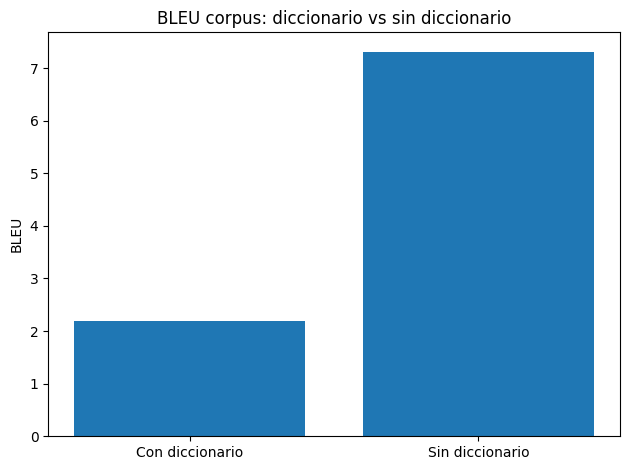

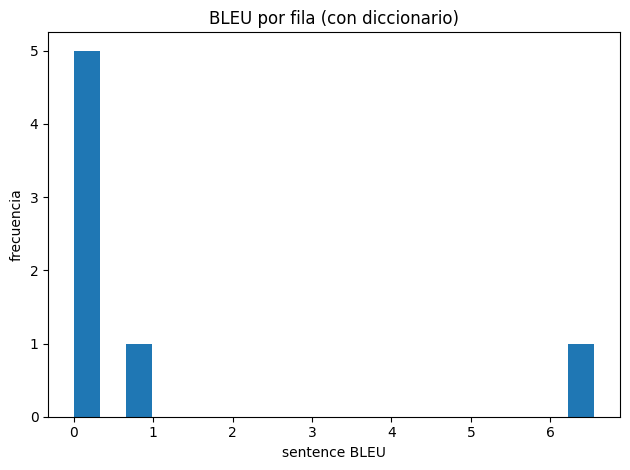

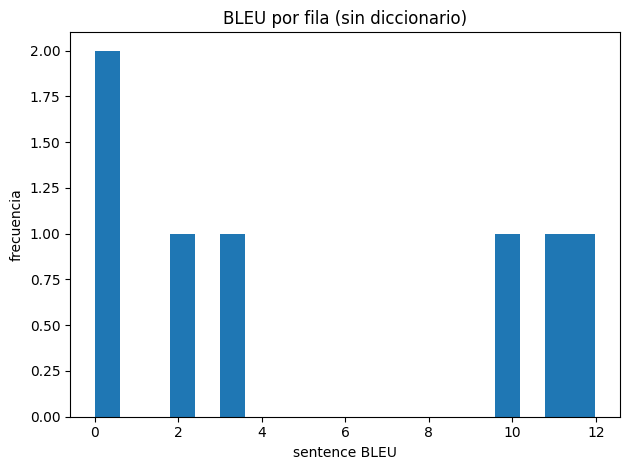

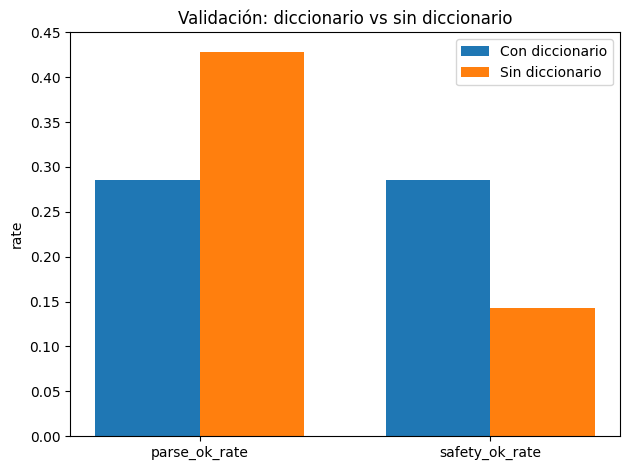

In [24]:
df_results = pd.read_parquet("val_dic_vs_nodic_results.parquet")

preds_dic = df_results["pred_sql_dic"].fillna("").astype(str).tolist()
preds_nod = df_results["pred_sql_nodic"].fillna("").astype(str).tolist()
refs = [[s] for s in df_results["gold_sql"].fillna("").astype(str).tolist()]

bleu_dic = bleu_metric.compute(predictions=preds_dic, references=refs)["score"]
bleu_nod = bleu_metric.compute(predictions=preds_nod, references=refs)["score"]

print("BLEU corpus con diccionario:", bleu_dic)
print("BLEU corpus sin diccionario:", bleu_nod)
print("Delta:", bleu_dic - bleu_nod)

# gráficos
plt.figure()
plt.bar(["Con diccionario", "Sin diccionario"], [bleu_dic, bleu_nod])
plt.title("BLEU corpus: diccionario vs sin diccionario")
plt.ylabel("BLEU")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(df_results["bleu_sentence_dic"].values, bins=20)
plt.title("BLEU por fila (con diccionario)")
plt.xlabel("sentence BLEU")
plt.ylabel("frecuencia")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(df_results["bleu_sentence_nodic"].values, bins=20)
plt.title("BLEU por fila (sin diccionario)")
plt.xlabel("sentence BLEU")
plt.ylabel("frecuencia")
plt.tight_layout()
plt.show()

# parse/safety rates
parse_dic = df_results["parse_ok_dic"].mean()
parse_nod = df_results["parse_ok_nodic"].mean()
safe_dic  = df_results["safety_ok_dic"].mean()
safe_nod  = df_results["safety_ok_nodic"].mean()

x = np.arange(2)
plt.figure()
plt.bar(x - 0.18, [parse_dic, safe_dic], 0.36, label="Con diccionario")
plt.bar(x + 0.18, [parse_nod, safe_nod], 0.36, label="Sin diccionario")
plt.xticks(x, ["parse_ok_rate", "safety_ok_rate"])
plt.title("Validación: diccionario vs sin diccionario")
plt.ylabel("rate")
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
PROMPTS_20 = [
    "Dame un SQL que muestre el total de ejecuciones por Proceso en el último mes, incluyendo cantidad y duración promedio.",
    "Genera un SQL para listar las 50 consultas más lentas (mayor Duracion_s) del último mes, con Proceso, Procedimiento y Usuario_hash.",
    "Necesito un SQL que muestre el top 10 de Procedimientos con más errores (Error=1) en los últimos 30 días.",
    "Dame un SQL para contar cuántas ejecuciones hubo por día (Inicio) en el último mes y ordenar por fecha ascendente.",
    "Genera un SQL que compare ejecuciones con error vs sin error por Proceso en el último mes (conteo y porcentaje).",
    "Dame un SQL para encontrar queries duplicadas (Query_normalizada) y cuántas veces se repiten en los últimos 90 días.",
    "Necesito un SQL que muestre el promedio y percentil 95 de Duracion_s por Proceso en el último mes.",
    "Genera un SQL para listar ejecuciones donde Duracion_s sea mayor a 120 segundos, con Inicio, Fin, Proceso y Query_normalizada.",
    "Dame un SQL que muestre la evolución semanal de errores (Error=1) durante los últimos 3 meses.",
    "Quiero un SQL que agrupe por Usuario_hash y muestre cuántas consultas ejecutó y cuántas fallaron en el último mes.",
    "Genera un SQL para obtener los procesos que no han corrido en los últimos 7 días (comparado contra el histórico).",
    "Dame un SQL que muestre la distribución por hora del día (hour(Inicio)) de ejecuciones en el último mes.",
    "Necesito un SQL que liste las 100 queries con más leads (Leads) en el último mes, con Proceso y Procedimiento.",
    "Genera un SQL para identificar el top 20 de Error_Mensaje más frecuentes en el último mes.",
    "Dame un SQL para extraer las ejecuciones que duraron menos de 1 segundo pero tuvieron Error=1 en el último mes.",
    "Necesito un SQL para contar ejecuciones por combinación (Proceso, Procedimiento) y ordenar por conteo desc en el último mes.",
    "Genera un SQL que devuelva el primer y último Inicio por Proceso en el último mes (min y max).",
    "Dame un SQL para identificar usuarios (Usuario_hash) que dispararon más de 200 ejecuciones en un día en el último mes.",
    "Necesito un SQL que liste las ejecuciones con Error=1 mostrando también la Query_normalizada y el Error_Mensaje, limitando a 200 filas.",
    "Genera un SQL para calcular la mora del proceso de cubo diario del último mes (si no hay tablas de mora, devuelve un comentario de falta de datos).",
]


In [32]:
import pandas as pd
import re

def executable_static(sql: str) -> bool:
    # Ejecutable "en principio" = parse_ok y safety_ok y no está vacío
    if sql is None:
        return False
    sql = str(sql).strip()
    if len(sql) == 0:
        return False
    if not parse_ok(sql):
        return False
    if not safety_ok(sql):
        return False
    return True


In [33]:
def executable_db(sql: str, conn) -> tuple[bool, str]:
    """
    Intenta ejecutar con un cursor. Recomendado: envolver el SQL con TOP para no traer data enorme.
    Retorna (ok, error_msg)
    """
    try:
        cur = conn.cursor()
        cur.execute(sql)
        # no hacemos fetchall masivo; solo un fetchone
        _ = cur.fetchone()
        return True, ""
    except Exception as e:
        return False, str(e)


In [38]:
def evaluar_20_prompts(
    prompts,
    top_k: int = 6,
    diccionario: bool = True,
    force_model: str | None = None,
    enable_fallback: bool = False,
    conn=None
):
    rows = []
    for i, q in enumerate(prompts, start=1):
        out = responder_sql(
            q,
            force_model=force_model,
            top_k=top_k,
            diccionario=diccionario
        )
        sql = out.get("sql", "")
        ok_static = executable_static(sql)

        ok_db = None
        err_db = None
        if conn is not None and ok_static:
            ok_db, err_db = executable_db(sql, conn)

        rows.append({
            "i": i,
            "prompt": q,
            "chosen_model": out.get("chosen_model", out.get("model")),
            "sql": sql,
            "parse_ok": int(parse_ok(sql)),
            "safety_ok": int(safety_ok(sql)),
            "executable_static": int(ok_static),
            "executable_db": ok_db,
            "db_error": err_db,
            "diccionario": diccionario
        })

    return pd.DataFrame(rows)

best_model = cargar_mejor_modelo()

df_dic = evaluar_20_prompts(PROMPTS_20, top_k=6, diccionario=True,  force_model=best_model,  conn=None)
df_nod = evaluar_20_prompts(PROMPTS_20, top_k=6, diccionario=False, force_model=best_model,  conn=None)

df_20 = pd.concat([df_dic, df_nod], ignore_index=True)
df_20



,i,prompt,chosen_model,sql,parse_ok,safety_ok,executable_static,executable_db,db_error,diccionario
0,1,Dame un SQL que muestre el total de ejecucione...,qwen25_coder_7b,"SELECT \n Proceso,\n COUNT(*) AS Cantida...",1,1,1,None,None,True
1,2,Genera un SQL para listar las 50 consultas más...,qwen25_coder_7b,"SELECT TOP 50 \n Proceso,\n Procedimient...",1,1,1,None,None,True
2,3,Necesito un SQL que muestre el top 10 de Proce...,qwen25_coder_7b,"SELECT TOP 10 \n PROCEDIMIENTO, \n COUNT...",1,1,1,None,None,True
3,4,Dame un SQL para contar cuántas ejecuciones hu...,qwen25_coder_7b,"SELECT \n CAST(Fecha AS DATE) AS Fecha,\n ...",1,1,1,None,None,True
4,5,Genera un SQL que compare ejecuciones con erro...,qwen25_coder_7b,WITH Ejecuciones AS (\n SELECT \n Pr...,1,1,1,None,None,True
5,6,Dame un SQL para encontrar queries duplicadas ...,qwen25_coder_7b,WITH Queries AS (\n SELECT \n SUBSTR...,1,1,1,None,None,True
6,7,Necesito un SQL que muestre el promedio y perc...,qwen25_coder_7b,WITH DuracionProcesos AS (\n SELECT \n ...,1,1,1,None,None,True
7,8,Genera un SQL para listar ejecuciones donde Du...,qwen25_coder_7b,"SELECT \n CONVERT(datetime, CAST(Ejecucion ...",1,1,1,None,None,True
8,9,Dame un SQL que muestre la evolución semanal d...,qwen25_coder_7b,WITH Semanal AS (\n SELECT \n DATEPA...,1,1,1,None,None,True
9,10,Quiero un SQL que agrupe por Usuario_hash y mu...,qwen25_coder_7b,WITH Consultas AS (\n SELECT \n usua...,1,1,1,None,None,True


In [40]:
df_20.to_csv("test_20.csv")

,diccionario,n,parse_ok_rate,safety_ok_rate,executable_rate
0,False,20,1.0,1.0,1.0
1,True,20,1.0,1.0,1.0


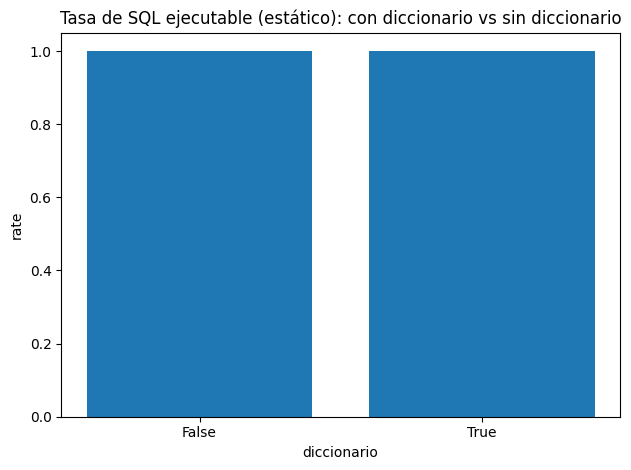

,diccionario,i,prompt,parse_ok,safety_ok,sql


In [39]:
import matplotlib.pyplot as plt
import numpy as np

summary_20 = (
    df_20.groupby("diccionario", as_index=False)
    .agg(
        n=("i","count"),
        parse_ok_rate=("parse_ok","mean"),
        safety_ok_rate=("safety_ok","mean"),
        executable_rate=("executable_static","mean"),
    )
)

display(summary_20)

plt.figure()
plt.bar(summary_20["diccionario"].astype(str), summary_20["executable_rate"])
plt.title("Tasa de SQL ejecutable (estático): con diccionario vs sin diccionario")
plt.xlabel("diccionario")
plt.ylabel("rate")
plt.tight_layout()
plt.show()

fail = df_20[df_20["executable_static"] == 0][["diccionario","i","prompt","parse_ok","safety_ok","sql"]]
display(fail.head(20))
